In [1]:
import os

# os.chdir(r"C:\Users\HP\Desktop\face_emotion_github\Face-Emotion-Recognition-main")
print(os.getcwd())

c:\Users\HP\Desktop\face_emotion_github\Face-Emotion-Recognition-main


In [2]:
#Import ML required packages
import numpy as np
import pandas as pd 
import keras
from keras.utils import to_categorical
#Import Libraries before model creation
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
#Load and Read the dataset
emotion_data = pd.read_csv('../Data/Fer2013/input/fer2013.csv')
print('Dataset loaded successfully')

Dataset loaded successfully


In [4]:
emotion_data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
emotion_data.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [6]:
emotion_data.Usage.value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [7]:
#Pull out dataset in different categories
data_train = emotion_data[emotion_data['Usage']== 'Training'].copy()
data_val = emotion_data[emotion_data['Usage']=='PublicTest'].copy()
data_test = emotion_data[emotion_data['Usage']=='PrivateTest'].copy()

In [8]:
print('Train shape: {}\nValidation shape: {}\nTest shape: {}'.format(data_train.shape,data_val.shape,data_test.shape))

Train shape: (28709, 3)
Validation shape: (3589, 3)
Test shape: (3589, 3)


In [9]:
#Initialize Parameters
num_classes = 7
epochs = 10
batch_size = 64
num_features = 32
width, height = 48,48

In [10]:
emotion_data.shape

(35887, 3)

In [11]:
emotion_data.describe()

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [12]:
#checking for missing values
emotion_data.isna().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

<Axes: ylabel='Count'>

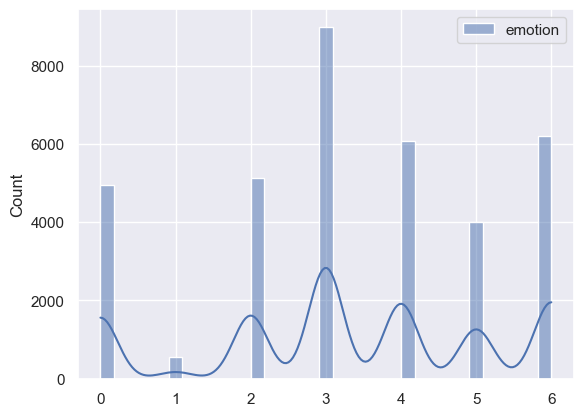

In [13]:
sns.set_theme(style='darkgrid', palette='deep', font='sans-serif', font_scale=1)
sns.histplot(data= emotion_data,kde = True)

In [14]:
#Data Preprocessing
#Perform CRNO (CRNO stands for Convert,Reshape, Normalize, one-hot-encoding)
def CRNO(df,dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(),dtype='float32').reshape(-1,width,height,1)/255.0
    data_Y = to_categorical(df['emotion'],num_classes)
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X,data_Y

In [15]:
train_X,train_Y = CRNO(data_train,'train')
val_X,val_Y = CRNO(data_val,'validation')
test_X,test_Y = CRNO(data_test,'test')

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
validation _X shape: {},  validation _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


### Enhanced VGG-16

In [17]:
#Build the model
model = Sequential()
#Module1 conv<<conv<<batchnorm<<relu<<maxpooling<<dropout   
model.add(Conv2D(2*num_features,kernel_size=(3,3),padding='same',data_format='channels_last',input_shape=(width, height, 1)))
model.add(Conv2D(2*num_features,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.2))
#Module2 conv<<conv<<batchnorm<<relu<<maxpool<<dropout
model.add(Conv2D(2*2*num_features,kernel_size=(3,3),padding='same'))
model.add(Conv2D(2*2*num_features,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.2))
#Module3 conv<<conv<<batchnorm<<relu<<maxpool<<dropout
model.add(Conv2D(2*2*2*num_features,kernel_size=(1,1),padding='same'))
model.add(Conv2D(2*2*2*num_features,kernel_size=(1,1),strides=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.2))
#Module4 fc<<batchnorm<<fc<<batchnorm<<dropout<<softmax
model.add(Flatten())
model.add(Dense(units=128))
model.add(BatchNormalization())
model.add(Dense(units=128))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))
model.add(Dense(num_classes,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0

In [19]:
import tensorflow as tf
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [21]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [20]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for d in devices:
    t = d.device_type
    name = d.physical_device_desc
    l = [item.split(':',1) for item in name.split(", ")]
    name_attr = dict([x for x in l if len(x)==2])
    dev = name_attr.get('name', 'Unnamed device')
    print(f" {d.name} || {dev} || {t} || {sizeof_fmt(d.memory_limit)}")

 /device:CPU:0 || Unnamed device || CPU || 256.0 MiB


In [22]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # Visible devices must be set at program startup
    print(e)

In [25]:
#Training the model
es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit(train_X,train_Y,batch_size=batch_size,epochs=20,verbose=2,callbacks=[es],validation_split=0,validation_data=(val_X,val_Y),shuffle=True)

Epoch 1/20
449/449 - 203s - loss: 1.7908 - accuracy: 0.3188 - val_loss: 1.9368 - val_accuracy: 0.3149 - 203s/epoch - 453ms/step
Epoch 2/20
449/449 - 193s - loss: 1.4818 - accuracy: 0.4379 - val_loss: 1.5152 - val_accuracy: 0.4263 - 193s/epoch - 429ms/step
Epoch 3/20
449/449 - 194s - loss: 1.3666 - accuracy: 0.4819 - val_loss: 1.3615 - val_accuracy: 0.4720 - 194s/epoch - 432ms/step
Epoch 4/20
449/449 - 194s - loss: 1.3100 - accuracy: 0.5047 - val_loss: 1.3430 - val_accuracy: 0.4965 - 194s/epoch - 432ms/step
Epoch 5/20
449/449 - 194s - loss: 1.2706 - accuracy: 0.5183 - val_loss: 1.3149 - val_accuracy: 0.4923 - 194s/epoch - 433ms/step
Epoch 6/20
449/449 - 199s - loss: 1.2497 - accuracy: 0.5265 - val_loss: 1.3081 - val_accuracy: 0.4857 - 199s/epoch - 443ms/step
Epoch 7/20
449/449 - 214s - loss: 1.2273 - accuracy: 0.5393 - val_loss: 1.2984 - val_accuracy: 0.5063 - 214s/epoch - 476ms/step
Epoch 8/20
449/449 - 244s - loss: 1.2052 - accuracy: 0.5435 - val_loss: 1.2474 - val_accuracy: 0.5305 - 

In [26]:
loss_and_metrics = model.evaluate(test_X,test_Y)
print(loss_and_metrics)

113/113 [==============================] - 8s 66ms/step - loss: 1.1624 - accuracy: 0.5634
[1.1623605489730835, 0.5633881092071533]


In [27]:
#Evaluate the test performance 
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

113/113 [==============================] - 11s 65ms/step
CNN Model Accuracy on test set: 0.5634


In [28]:
import json
model_json = model.to_json()
with open("../Models/Change_vgg/model.json", "w") as json_file:
  json_file.write(model_json)
  model.save_weights("../Models/Change_vgg/model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor_kernel

# Define function to extract LBP features
def extract_lbp_features(image):
    # define the LBP parameters
    radius = 3
    n_points = 8 * radius
    method = 'uniform'
    
    # compute the LBP features for the image
    lbp = local_binary_pattern(image, n_points, radius, method)
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    
    # return the features as a 1D NumPy array
    return hist.ravel()

# Define function to extract HOG features
def extract_hog_features(image):
    # define the HOG parameters
    orientations = 9
    pixels_per_cell = (8, 8)
    cells_per_block = (2, 2)
    visualize = False
    
    # compute the HOG features for the image
    hog_features = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block, visualize=visualize)
    
    # return the features as a 1D NumPy array
    return hog_features.ravel()

# Define function to extract Gabor features
def extract_gabor_features(image):
    # define the Gabor parameters
    freqs = [0.05, 0.1, 0.2]
    thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    kernels = []
    
    # create the Gabor kernels
    for freq in freqs:
        for theta in thetas:
            kernel = np.real(gabor_kernel(freq, theta=theta))
            kernels.append(kernel)
            
    # compute the Gabor features for the image
    gabor_features = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        gabor_features[k, 0] = filtered.mean()
        gabor_features[k, 1] = filtered.var()
    
    # return the features as a 1D NumPy array
    return gabor_features.ravel()

# Define the model architecture
input_shape = (width, height, 1)
input_layer = Input(shape=input_shape)

# Convolutional layers for image data
x = Conv2D(32, kernel_size=(3,3), activation='relu')(input_layer)
x = MaxPooling2D()(x)
x = Conv2D(64, kernel_size=(3,3), activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(128, kernel_size=(3,3), activation='relu')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)

# Fully connected layers for LBP, HOG, and Gabor features
lbp_fc1 = Dense(128, activation='relu')(lbp_input)
hog_fc1 = Dense(128, activation='relu')(hog_input)
gabor_fc1 = Dense(128, activation='relu')(gabor_input)

concatenated = Concatenate()([lbp_fc1, hog_fc1, gabor_fc1])

x = Dense(64, activation='relu')(concatenated)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
output = Dense(7, activation='softmax')(x)

model = Model(inputs=[lbp_input, hog_input, gabor_input], outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit([lbp_train, hog_train, gabor_train], y_train, epochs=20, batch_size=32, validation_data=([lbp_val, hog_val, gabor_val], y_val))

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate([landmark_test, texture_test, lbp_test, hog_test, gabor_test], y_test)

# Print the test accuracy
print('Test accuracy:', test_acc)

In [ ]:
import cv2
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor_kernel
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# load the landmark_train, texture_train, landmark_val, and texture_val datasets

# extract HOG features
def extract_hog_features(images):
    features = []
    for img in images:
        img = cv2.resize(img, (64, 64))
        fd = hog(img, orientations=9, pixels_per_cell=(8, 8),
                 cells_per_block=(2, 2), visualize=False, multichannel=True)
        features.append(fd)
    return features

train_hog = extract_hog_features(landmark_train)
val_hog = extract_hog_features(landmark_val)

# extract LBP features
def extract_lbp_features(images):
    features = []
    for img in images:
        img = cv2.resize(img, (64, 64))
        lbp = local_binary_pattern(img, 8, 1, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        features.append(hist)
    return features

train_lbp = extract_lbp_features(texture_train)
val_lbp = extract_lbp_features(texture_val)

# extract Gabor features
def extract_gabor_features(images):
    features = []
    for img in images:
        img = cv2.resize(img, (64, 64))
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        feats = []
        for k in range(3):
            kernel = np.real(gabor_kernel(0.4, theta=k*np.pi/3, sigma_x=1, sigma_y=1))
            filtered = cv2.filter2D(gray_img, cv2.CV_8UC3, kernel)
            feats.append(filtered)
        feats = np.array(feats)
        features.append(feats.flatten())
    return features

train_gabor = extract_gabor_features(texture_train)
val_gabor = extract_gabor_features(texture_val)

# concatenate all features
train_features = np.concatenate([train_hog, train_lbp, train_gabor], axis=1)
val_features = np.concatenate([val_hog, val_lbp, val_gabor], axis=1)

# define the model architecture
inputs = Input(shape=(train_features.shape[1],))
x = Dense(128, activation='relu')(inputs)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999), metrics=['accuracy'])

# train the model
history = model.fit(train_features, train_Y, batch_size=32, epochs=50, validation_data=(val_features, val_Y))


In [ ]:
import cv2
import dlib
import numpy as np

# Load the face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('path/to/shape_predictor_68_face_landmarks.dat')

# Function to extract LBP features from an image
def extract_lbp_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = cv2.spatial_histogram(gray, [8,8], 256, True)
    return lbp.flatten()

# Function to extract facial landmarks and LBP features from an image
def extract_features(image_path):
    image = cv2.imread(image_path)
    # Detect faces in the image
    faces = detector(image)
    # Extract landmark and LBP features for each face
    landmarks = []
    textures = []
    for face in faces:
        # Extract landmark features
        shape = predictor(image, face)
        landmarks.append(np.array([(shape.part(i).x, shape.part(i).y) for i in range(68)]))
        # Extract texture features
        texture = extract_lbp_features(cv2.resize(image[face.top():face.bottom(), face.left():face.right()], (256, 256)))
        textures.append(texture)
    return np.array(landmarks), np.array(textures)

# Example usage
landmark_train = []
texture_train = []
landmark_val = []
texture_val = []

# Iterate over training images
for i in range(len(train_image_paths)):
    landmarks, textures = extract_features(train_image_paths[i])
    landmark_train.append(landmarks)
    texture_train.append(textures)

# Iterate over validation images
for i in range(len(val_image_paths)):
    landmarks, textures = extract_features(val_image_paths[i])
    landmark_val.append(landmarks)
    texture_val.append(textures)

# Convert to numpy arrays
landmark_train = np.array(landmark_train)
texture_train = np.array(texture_train)
landmark_val = np.array(landmark_val)
texture_val = np.array(texture_val)


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming you have your landmark and texture features stored in arrays
landmark = ...
texture = ...

# Split the landmark and texture features into training and validation sets
landmark_train, landmark_val, texture_train, texture_val = train_test_split(landmark, texture, test_size=0.2, random_state=42)


In [ ]:
# Define the model architecture
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Add feature extraction layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))

# Define additional feature inputs
landmark_input = Input(shape=(68, 2), name='landmark_input')
texture_input = Input(shape=(256,), name='texture_input')

# Concatenate features with output of convolutional layers
conv_output = model.layers[-2].output
concat_layer = Concatenate()([conv_output, landmark_input, texture_input])

# Add dense layers
dense_layer = Dense(256, activation='relu')(concat_layer)
output_layer = Dense(num_classes, activation='softmax')(dense_layer)

# Define the complete model
complete_model = Model(inputs=[model.input, landmark_input, texture_input], outputs=output_layer)

# Compile the model
complete_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Train the model with all inputs
history = complete_model.fit([X_train, landmark_train, texture_train], y_train, epochs=10, batch_size=32, validation_data=([X_val, landmark_val, texture_val], y_val))
